In [1]:
%matplotlib inline

import dicom
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from glob import glob

dsb_path = "/home/anon/kaggle_dsb/1/study/"
label_path = "/home/anon/regional_label_np/train/1/study/"
subdirs = glob(label_path + '/*/')
labels = []
images = []

side_crop = 60

for subdir in subdirs:
    images_path = glob(subdir + '/*.npy')
    for image_path in images_path:
        dicom_end_path = image_path[image_path.rfind('/study/') + len('/study/'):image_path.rfind('.npy')]
        dc = dicom.read_file(dsb_path + dicom_end_path + '.dcm')
        image = dc.pixel_array
        image = image[side_crop:image.shape[0] - side_crop, side_crop:image.shape[1] - side_crop]
        images.append(image)
#         img=mpimg.imread(image_path)
#         img = img.copy()
        img = np.load(image_path)
        img = img[side_crop:img.shape[0] - side_crop, side_crop:img.shape[1] - side_crop]
        img[img < 20] = 0
        img[(img >= 20) & (img < 40)] = 1
        img[(img >= 40) & (img < 60)] = 2
        img[(img >= 60) & (img < 80)] = 3
        img[(img >= 80) & (img < 100)] = 4
        img[(img >= 100) & (img < 120)] = 5
        img[img >= 120] = 6
        
        labels.append(img)

# for i in range(50):
#     fig, ax = plt.subplots(figsize=(8, 6))
#     plt.imshow(images[i])
#     plt.show()
#     fig, ax = plt.subplots(figsize=(8, 6))
#     plt.imshow(labels[i])
#     plt.show()
print(len(images))
print(len(labels))

# np.set_printoptions(threshold=np.nan)
# print(labels[0][120:140, 100:130])

# fig, ax = plt.subplots(figsize=(10, 8))
# plt.imshow(labels[100])
# print(labels[100][40:80, 55:70])

X = np.rollaxis(np.dstack(images), -1)
Y = np.rollaxis(np.dstack(labels), -1)
print(X.shape, Y.shape)

330
330
((330, 136, 110), (330, 136, 110))


(104, (104, 136, 110), (104, 136, 110))
(40, 49)
(60, 43)
(72, 54)
(54, 61)
(50, 79)
(70, 70)
(37, 66)


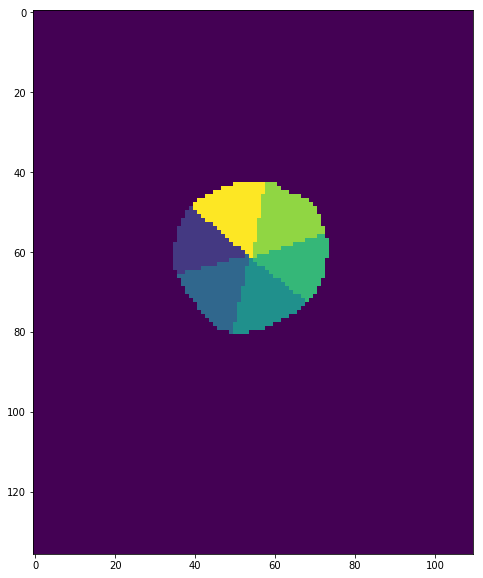

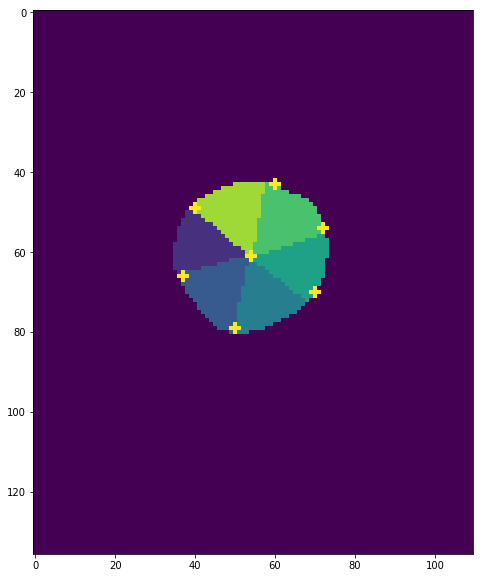

(<matplotlib.image.AxesImage at 0x7f6eab960f50>, None)

In [15]:
import cv2

# img = Y[100]
# fig, ax = plt.subplots(figsize=(12, 10))
# plt.imshow(img)

fav_X = np.zeros((104, X.shape[1], X.shape[2]))
fav_Y = np.zeros((104, Y.shape[1], Y.shape[2]), dtype=np.int32)
fav_corners = np.zeros((104, 7, 2), dtype=np.int0) # 7 corners for each fav image
# dst = cv2.cornerHarris(Y[100],2,3,0.04)
# fig, ax = plt.subplots(figsize=(12, 10))
# plt.imshow(dst)
counter = 0
index = 0
for i in range(Y.shape[0]):
    corners = cv2.goodFeaturesToTrack(Y[i],7,0.01,14)
    corners = np.int0(corners)
    if corners.shape[0] == 7:
        fav_X[index] = X[i]
        fav_Y[index] = Y[i]
        fav_corners[index] = corners.reshape((7, 2))
        index += 1
        counter += 1
        
print(counter, fav_X.shape, fav_Y.shape)


z = fav_Y[60].copy()
fig, ax = plt.subplots(figsize=(12, 10))
plt.imshow(z)

for i in fav_corners[60]:
    x,y = i.ravel()
    print(x, y)
    cv2.circle(z,(x,y),1,7,-1)

fig, ax = plt.subplots(figsize=(12, 10))
plt.imshow(z),plt.show()

In [4]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 16
num_classes = 7 # per pixel
smooth_factor = 1.0

# input image dimensions
img_rows, img_cols = fav_X.shape[1], fav_X.shape[2]

# the data, shuffled and split between train and test sets
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
np.random.shuffle(fav_X)
np.random.shuffle(fav_Y)

x_train = fav_X[:80]
x_test = fav_X[80:]
y_train = fav_Y[:80]
y_test = fav_Y[80:]

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train_one_hot = np.zeros([y_train.shape[0], y_train.shape[1], y_train.shape[2], num_classes])
y_test_one_hot = np.zeros([y_test.shape[0], y_test.shape[1], y_test.shape[2], num_classes])

# one-hotize
for instance_index in range(y_train.shape[0]):
    for row_ind in range(y_train.shape[1]):
        for col_ind in range(y_train.shape[2]):
            pixel_label = y_train[instance_index, row_ind, col_ind]
            y_train_one_hot[instance_index, row_ind, col_ind, pixel_label] = 1

for instance_index in range(y_test.shape[0]):
    for row_ind in range(y_test.shape[1]):
        for col_ind in range(y_test.shape[2]):
            pixel_label = y_test[instance_index, row_ind, col_ind]
            y_test_one_hot[instance_index, row_ind, col_ind, pixel_label] = 1


def dice_coef(y_true, y_pred):
    print(y_true)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth_factor) / \
           (K.sum(y_true_f) + K.sum(y_pred_f) + smooth_factor)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

print('x_train shape:', x_train.shape)
print('y_train_one_hot shape:', y_train_one_hot.shape)
print(y_train[100, 70, 60])
print(y_train_one_hot[100, 70, 60, :])

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding="same",
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(num_classes, (1, 1), activation='softmax', padding="same", name="predictions"))
# model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=dice_coef_loss,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# model.compile(optimizer=keras.optimizers.Adadelta(),
#               loss=keras.losses.categorical_crossentropy,
#               metrics=["accuracy"])

model.summary()

model.fit(x_train, y_train_one_hot,
          batch_size=batch_size,
          epochs=20,
          verbose=1, validation_data=(x_test, y_test_one_hot))

sample_output = model.predict_on_batch(x_test[0:5])
print(sample_output.shape)

# score = model.evaluate(x_test, y_test_one_hot, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

150 train samples
60 test samples
x_train shape: (150, 136, 110, 1)
y_train_one_hot shape: (150, 136, 110, 7)
3
[ 0.  0.  0.  1.  0.  0.  0.]
Tensor("predictions_target_2:0", shape=(?, ?, ?, ?), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 136, 110, 32)      320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 136, 110, 32)      9248      
_________________________________________________________________
predictions (Conv2D)         (None, 136, 110, 7)       231       
Total params: 9,799
Trainable params: 9,799
Non-trainable params: 0
_________________________________________________________________
Train on 150 samples, validate on 60 samples
Epoch 1/20
150/150 [==============================] - 4s - loss: -0.1591 - acc: 0.6865 - val_loss: -0.1875 - val_acc: 0.9627
Epoch 2/20
128/150 [====

KeyboardInterrupt: 

0.999999822583
(136, 110, 7)
(136, 110, 7)
(136, 110, 7)
(136, 110, 7)
(136, 110, 7)


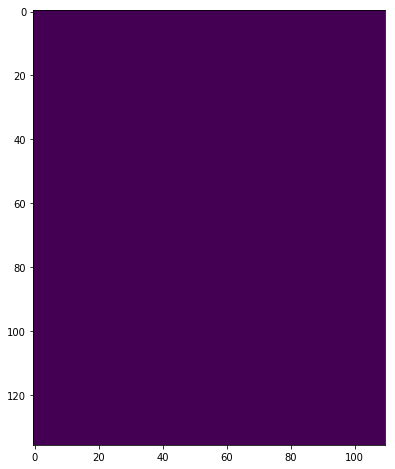

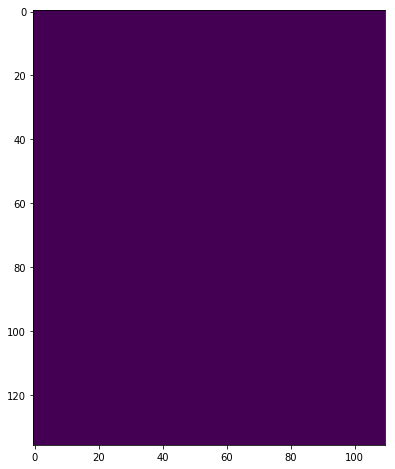

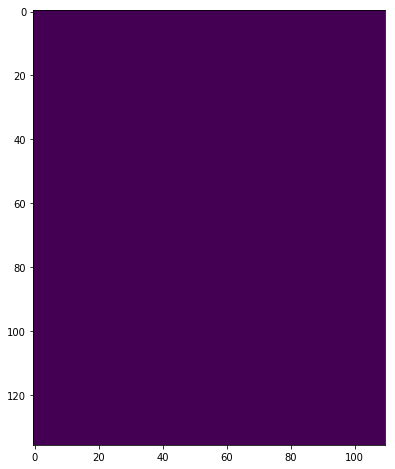

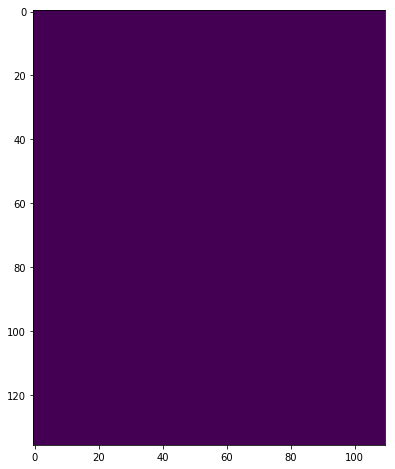

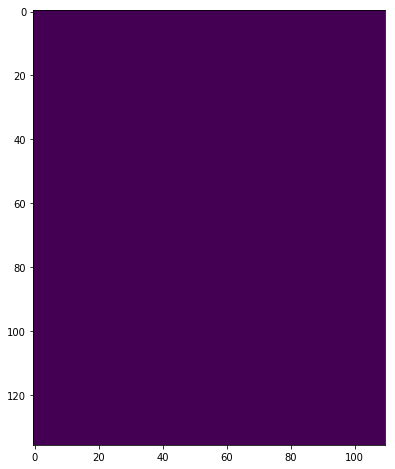

In [3]:
print(sum(sample_output[1, 30, 20, :]))

for i in range(sample_output.shape[0]):
    pred_image = sample_output[i]
    print(pred_image.shape)
    visualize = np.zeros([pred_image.shape[0], pred_image.shape[1]])

    for row_ind in range(visualize.shape[0]):
        for col_ind in range(visualize.shape[1]):
            visualize[row_ind, col_ind] = np.argmax(pred_image[row_ind, col_ind, :])

    fig, ax = plt.subplots(figsize=(10, 8))
    plt.imshow(visualize)
# print(labels[100][40:80, 55:70])